# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [164]:
#!pip install citipy
from citipy import citipy

#Set dependencies
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import scipy.stats as st
from scipy.stats import linregress

#import api key
from api_keys import weather_api_key

#Range of latitudes and longitudes
range_lat = (-90,90)
range_lng = (-180,180)

## Generate Cities List

In [4]:
#empty lists to hold data
lat_lng_list = []
city_list = []

#generate random latitudes and longitudes
lats = np.random.uniform(range_lat[0],range_lat[1],size=1500)
lngs = np.random.uniform(range_lng[0],range_lng[1],size=1500)

#zip latitudes and longitudes together
lat_lng_list = zip(lats,lngs)

#identify city based on lat/lng
for lat_lng in lat_lng_list:
    city = citipy.nearest_city(lat_lng[0],lat_lng[1]).city_name
    if city not in city_list:
        city_list.append(city)

#find number of cities
len(city_list)

618

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [5]:
#put list of cities into a data frame
city_df = pd.DataFrame(city_list)
city_df = city_df.rename(columns = {0:'City'})

#add additional columns
city_df['Lat']=""
city_df['Lng']=""
city_df['Max Temp']=""
city_df['Humidity']=""
city_df['Cloudiness']=""
city_df['Wind Speed']=""
city_df['Country']=""
city_df['Date']=""

#retrieve data

In [58]:
url = "http://api.openweathermap.org/data/2.5/weather?"
record_count = 0
set_count = 1

print("Beginning Data Retrieval")
print("--------------------------")

#iterate through the city df
for index,row in city_df.iterrows():
    #access api
    city_name = row["City"]
    city_url = f'{url}appid={weather_api_key}&q={city_name.replace(" ", "")}&units=imperial'
    response = requests.get(city_url).json()
    if record_count < 50:
        record_count = record_count +1
    else:
        set_count = set_count + 1
        record_count = 1
    print(f'Processing Record {record_count} of Set {set_count}| {city_name}')
    #add information to city df
    try:
        city_df.loc[index, "Lat"]=response['coord']['lat']
        city_df.loc[index, "Lng"]=response['coord']['lon']
        city_df.loc[index, "Max Temp"]=response['main']['temp_max']
        city_df.loc[index, "Humidity"]=response['main']['humidity']
        city_df.loc[index, "Cloudiness"]=response['clouds']['all']
        city_df.loc[index, "Wind Speed"]=response['wind']['speed']
        city_df.loc[index, "Country"]=response['sys']['country']
        city_df.loc[index, "Date"]=response['dt']
    except (KeyError, IndexError):
        city_df.drop(index)
        print("City not found. Skipping...")
    time.sleep(1.5)
print("---------------------------")
print("Data Retrieval Complete")
print("---------------------------")

Beginning Data Retrieval
--------------------------
Processing Record 1 of Set 1| hermanus
Processing Record 2 of Set 1| mataura
Processing Record 3 of Set 1| kalaiya
Processing Record 4 of Set 1| hilo
Processing Record 5 of Set 1| longyearbyen
Processing Record 6 of Set 1| rikitea
Processing Record 7 of Set 1| marsh harbour
City not found. Skipping...
Processing Record 8 of Set 1| sinnamary
Processing Record 9 of Set 1| gat
Processing Record 10 of Set 1| atuona
Processing Record 11 of Set 1| torbay
Processing Record 12 of Set 1| lahat
Processing Record 13 of Set 1| beloha
Processing Record 14 of Set 1| new norfolk
City not found. Skipping...
Processing Record 15 of Set 1| port elizabeth
City not found. Skipping...
Processing Record 16 of Set 1| bathsheba
Processing Record 17 of Set 1| klaksvik
Processing Record 18 of Set 1| illoqqortoormiut
City not found. Skipping...
Processing Record 19 of Set 1| taolanaro
City not found. Skipping...
Processing Record 20 of Set 1| port alfred
City n

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [117]:
clean_df = city_df
clean_df = clean_df.replace('', np.nan)
clean_df = clean_df.dropna()
clean_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,hermanus,-34.4187,19.2345,73.99,70.0,95.0,3.00,ZA,1.616707e+09
1,mataura,-46.1927,168.8643,55.00,97.0,73.0,3.00,NZ,1.616707e+09
2,kalaiya,27.0327,85.0022,68.63,16.0,0.0,4.63,NP,1.616707e+09
3,hilo,19.7297,-155.0900,80.60,65.0,90.0,10.36,US,1.616707e+09
4,longyearbyen,78.2186,15.6401,23.00,68.0,75.0,13.80,SJ,1.616707e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [122]:
low_humidity_df = clean_df.loc[(clean_df["Humidity"])<=100]

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,hermanus,-34.4187,19.2345,73.99,70.0,95.0,3.00,ZA,1.616707e+09
1,mataura,-46.1927,168.8643,55.00,97.0,73.0,3.00,NZ,1.616707e+09
2,kalaiya,27.0327,85.0022,68.63,16.0,0.0,4.63,NP,1.616707e+09
3,hilo,19.7297,-155.0900,80.60,65.0,90.0,10.36,US,1.616707e+09
4,longyearbyen,78.2186,15.6401,23.00,68.0,75.0,13.80,SJ,1.616707e+09
...,...,...,...,...,...,...,...,...,...
613,asosa,10.0667,34.5333,73.22,38.0,5.0,1.59,ET,1.616708e+09
614,norilsk,69.3535,88.2027,14.92,93.0,100.0,8.32,RU,1.616708e+09
615,saint-felicien,48.6501,-72.4491,55.40,62.0,90.0,16.11,CA,1.616708e+09
616,lubao,14.9167,120.5500,75.20,78.0,40.0,2.30,PH,1.616708e+09


In [126]:
#  Get the indices of cities that have humidity over 100%.
high_humidity_df = clean_df.loc[(clean_df["Humidity"])>100]
index = high_humidity_df.index
condition = high_humidity_df["Humidity"]>100
high_humidity_indices = index[condition]
high_humidity_list = high_humidity_indices.tolist()
high_humidity_list

[]

In [127]:
# Make a new DataFrame equal to the city data to drop all humidity outliers which we call "clean_city_data".
clean_city_data = low_humidity_df
clean_city_data

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,hermanus,-34.4187,19.2345,73.99,70.0,95.0,3.00,ZA,1.616707e+09
1,mataura,-46.1927,168.8643,55.00,97.0,73.0,3.00,NZ,1.616707e+09
2,kalaiya,27.0327,85.0022,68.63,16.0,0.0,4.63,NP,1.616707e+09
3,hilo,19.7297,-155.0900,80.60,65.0,90.0,10.36,US,1.616707e+09
4,longyearbyen,78.2186,15.6401,23.00,68.0,75.0,13.80,SJ,1.616707e+09
...,...,...,...,...,...,...,...,...,...
613,asosa,10.0667,34.5333,73.22,38.0,5.0,1.59,ET,1.616708e+09
614,norilsk,69.3535,88.2027,14.92,93.0,100.0,8.32,RU,1.616708e+09
615,saint-felicien,48.6501,-72.4491,55.40,62.0,90.0,16.11,CA,1.616708e+09
616,lubao,14.9167,120.5500,75.20,78.0,40.0,2.30,PH,1.616708e+09


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

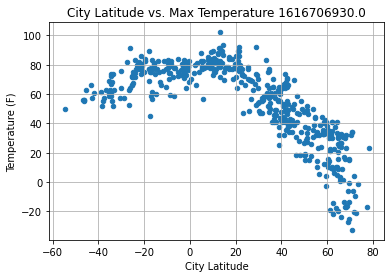

In [147]:
# Generate a scatter plot of city latitude vs. city temperature
date = clean_city_data["Date"][0]
scatter_df = pd.DataFrame({"City Latitude":clean_city_data["Lat"],
                          "Temperature (F)": clean_city_data["Max Temp"]})
scatter_df.plot(kind = "scatter", x = "City Latitude", y = "Temperature (F)",grid = True);

plt.title(f"City Latitude vs. Max Temperature {date}");

## Latitude vs. Humidity Plot

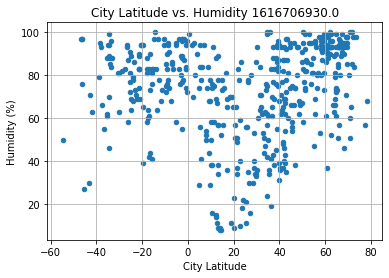

In [159]:
# Generate a scatter plot of city latitude vs. city humidity
date = clean_city_data["Date"][0]
scatter_df = pd.DataFrame({"City Latitude":clean_city_data["Lat"],
                          "Humidity (%)": clean_city_data["Humidity"]})
scatter_df.plot(kind = "scatter", x = "City Latitude", y = "Humidity (%)",grid = True);

plt.title(f"City Latitude vs. Humidity {date}");

## Latitude vs. Cloudiness Plot

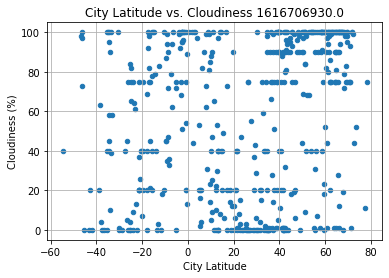

In [160]:
# Generate a scatter plot of city latitude vs. city cloudiness
date = clean_city_data["Date"][0]
scatter_df = pd.DataFrame({"City Latitude":clean_city_data["Lat"],
                          "Cloudiness (%)": clean_city_data["Cloudiness"]})
scatter_df.plot(kind = "scatter", x = "City Latitude", y = "Cloudiness (%)",grid = True);

plt.title(f"City Latitude vs. Cloudiness {date}");

## Latitude vs. Wind Speed Plot

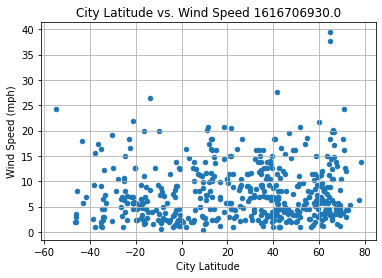

In [161]:
# Generate a scatter plot of city latitude vs. city wind speed
date = clean_city_data["Date"][0]
scatter_df = pd.DataFrame({"City Latitude":clean_city_data["Lat"],
                          "Wind Speed (mph)": clean_city_data["Wind Speed"]})
scatter_df.plot(kind = "scatter", x = "City Latitude", y = "Wind Speed (mph)",grid = True);

plt.title(f"City Latitude vs. Wind Speed {date}");

## Linear Regression

In [24]:
#create df for northern and southern hemispheres
northern_hemisphere_df = clean_city_data.loc[clean_city_data["Lat"]>0]
southern_hemisphere_df = clean_city_data.loc[clean_city_data["Lat"]<0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is -0.87


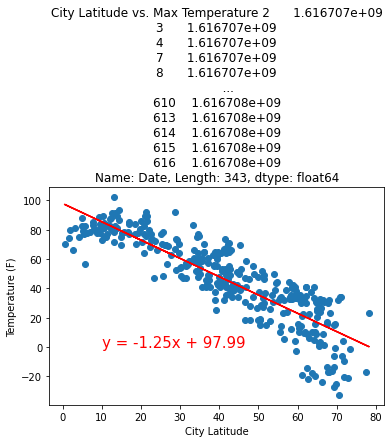

In [171]:
correlation = st.pearsonr(northern_hemisphere_df["Lat"],northern_hemisphere_df["Max Temp"])
print(f"The r-value is {round(correlation[0],2)}")
date = northern_hemisphere_df["Date"]
x_values = northern_hemisphere_df["Lat"]
y_values =  northern_hemisphere_df["Max Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10,0),fontsize=15,color="red")
plt.xlabel('City Latitude')
plt.ylabel('Temperature (F)')
plt.title(f"City Latitude vs. Max Temperature {date}");
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is 0.57


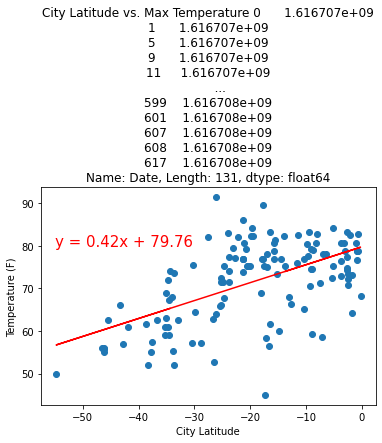

In [175]:
correlation = st.pearsonr(southern_hemisphere_df["Lat"],southern_hemisphere_df["Max Temp"])
print(f"The r-value is {round(correlation[0],2)}")
date = southern_hemisphere_df["Date"]
x_values = southern_hemisphere_df["Lat"]
y_values =  southern_hemisphere_df["Max Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,80),fontsize=15,color="red")
plt.xlabel('City Latitude')
plt.ylabel('Temperature (F)')
plt.title(f"City Latitude vs. Max Temperature {date}");
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is 0.46


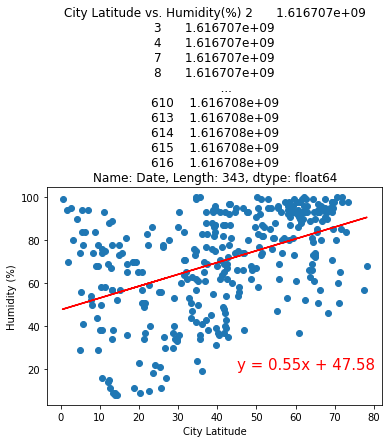

In [178]:
correlation = st.pearsonr(northern_hemisphere_df["Lat"],northern_hemisphere_df["Humidity"])
print(f"The r-value is {round(correlation[0],2)}")
date = northern_hemisphere_df["Date"]
x_values = northern_hemisphere_df["Lat"]
y_values =  northern_hemisphere_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(45,20),fontsize=15,color="red")
plt.xlabel('City Latitude')
plt.ylabel('Humidity (%)')
plt.title(f"City Latitude vs. Humidity(%) {date}");
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is 0.21


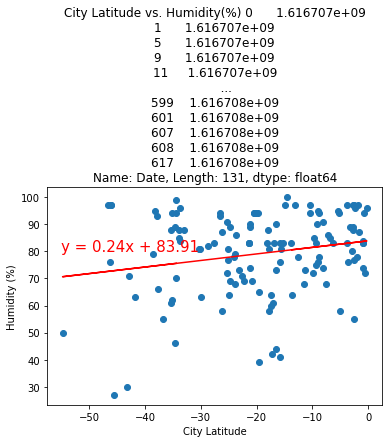

In [182]:
correlation = st.pearsonr(southern_hemisphere_df["Lat"],southern_hemisphere_df["Humidity"])
print(f"The r-value is {round(correlation[0],2)}")
date = southern_hemisphere_df["Date"]
x_values = southern_hemisphere_df["Lat"]
y_values =  southern_hemisphere_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,80),fontsize=15,color="red")
plt.xlabel('City Latitude')
plt.ylabel('Humidity (%)')
plt.title(f"City Latitude vs. Humidity(%) {date}");
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is 0.37


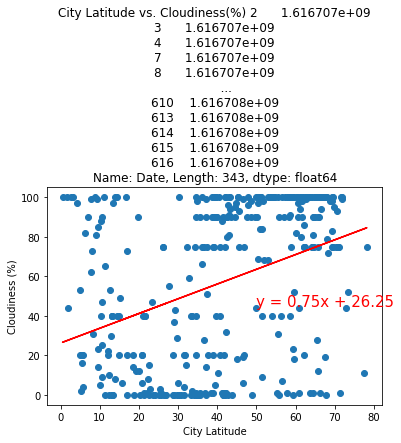

In [180]:
correlation = st.pearsonr(northern_hemisphere_df["Lat"],northern_hemisphere_df["Cloudiness"])
print(f"The r-value is {round(correlation[0],2)}")
date = northern_hemisphere_df["Date"]
x_values = northern_hemisphere_df["Lat"]
y_values =  northern_hemisphere_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(50,45),fontsize=15,color="red")
plt.xlabel('City Latitude')
plt.ylabel('Cloudiness (%)')
plt.title(f"City Latitude vs. Cloudiness(%) {date}");
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is 0.27


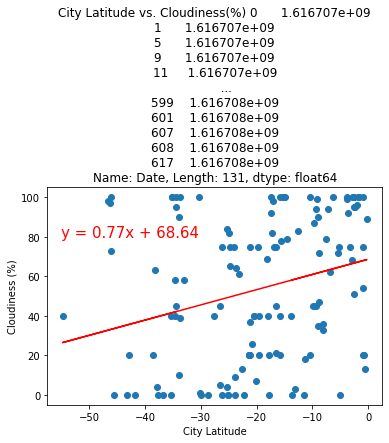

In [183]:
correlation = st.pearsonr(southern_hemisphere_df["Lat"],southern_hemisphere_df["Cloudiness"])
print(f"The r-value is {round(correlation[0],2)}")
date = southern_hemisphere_df["Date"]
x_values = southern_hemisphere_df["Lat"]
y_values =  southern_hemisphere_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,80),fontsize=15,color="red")
plt.xlabel('City Latitude')
plt.ylabel('Cloudiness (%)')
plt.title(f"City Latitude vs. Cloudiness(%) {date}");
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is -0.01


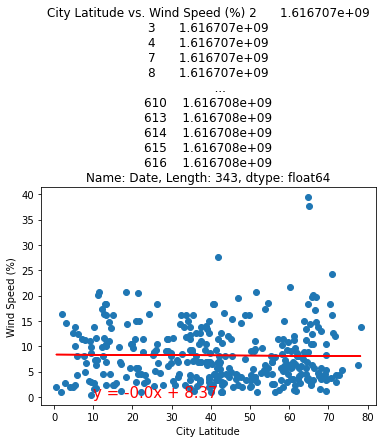

In [181]:
correlation = st.pearsonr(northern_hemisphere_df["Lat"],northern_hemisphere_df["Wind Speed"])
print(f"The r-value is {round(correlation[0],2)}")
date = northern_hemisphere_df["Date"]
x_values = northern_hemisphere_df["Lat"]
y_values =  northern_hemisphere_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10,0),fontsize=15,color="red")
plt.xlabel('City Latitude')
plt.ylabel('Wind Speed (%)')
plt.title(f"City Latitude vs. Wind Speed (%) {date}");
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is -0.17


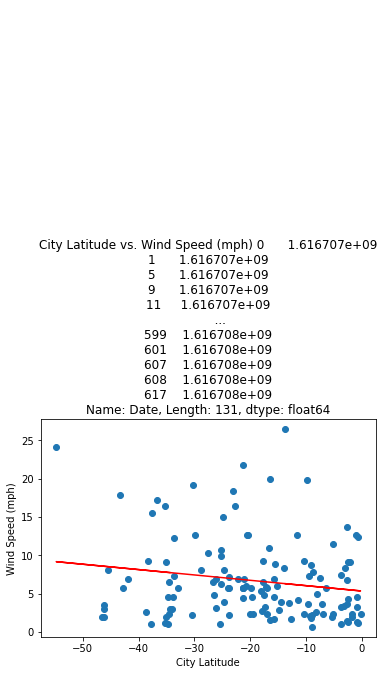

In [184]:
correlation = st.pearsonr(southern_hemisphere_df["Lat"],southern_hemisphere_df["Wind Speed"])
print(f"The r-value is {round(correlation[0],2)}")
date = southern_hemisphere_df["Date"]
x_values = southern_hemisphere_df["Lat"]
y_values =  southern_hemisphere_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,80),fontsize=15,color="red")
plt.xlabel('City Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title(f"City Latitude vs. Wind Speed (mph) {date}");
plt.show()